In [3]:
# from pyglmnet import GLM
import numpy as np
import pandas as pd
from importlib import reload
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')
import xarray as xr
from utils import lda_angle_discrim as lad
from sklearn.linear_model import ElasticNet

base_dir = Path(r'D:\JK\h5')
results_dir = base_dir / 'results'
wf_dir = results_dir / 'touch_whisker_features'
b_dir = Path(r'D:\JK\SoloData')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]
use_volume_df = use_mice_df.query('plane in [1, 5]')
use_volume_df.loc[:, 'volume'] = use_volume_df['plane'].apply(lambda x: 1 if x==1 else 2)
training_volume_df = use_volume_df.query('session_type == "training"')
remove_ind = training_volume_df.query('mouse==27 and session=="15"')
training_volume_df = training_volume_df.drop(remove_ind.index)
remove_ind = training_volume_df.query('mouse==36 and session=="9"')
training_volume_df = training_volume_df.drop(remove_ind.index)

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]
naive_sessions = [10, 4, 11, 6, 6, 11]

c:\Users\shires\.conda\envs\suite2p\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [4]:
ridge_dir = results_dir / 'neuron_glm/ridge/whisker_combined'
lasso_dir = results_dir / 'neuron_glm/lasso/whisker_combined'

In [5]:
mouse = 25
plane = 1
session = 1
design_pkl = ridge_dir / f'JK{mouse:03}S{session:02}_plane{plane}_design_whisker_combined.pkl'
design = pd.read_pickle(design_pkl)
split_fn = ridge_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_split.npy'
split = np.load(split_fn, allow_pickle=True).item()

In [9]:
result_fn = ridge_dir / f'JK{mouse:03}S{session:02}_plane{plane}_glm_result.nc'
with xr.open_dataset(result_fn) as ds:
    traces = ds['traces']
    X = ds['X']

In [10]:
traces

<xarray.DataArray 'traces' (index: 4106, cell_id: 120)>
[492720 values with dtype=float32]
Coordinates:
  * index    (index) int32 0 1 2 3 4 5 6 ... 4099 4100 4101 4102 4103 4104 4105
  * cell_id  (cell_id) int32 0 1 2 4 5 7 8 9 ... 138 139 140 141 142 143 144 145

In [11]:
X

<xarray.DataArray 'X' (index: 4106, feature: 88)>
[361328 values with dtype=float64]
Coordinates:
  * index    (index) int32 0 1 2 3 4 5 6 ... 4099 4100 4101 4102 4103 4104 4105
  * feature  (feature) object 'intercept' ... 'first_reward_lick_right_4'

In [68]:
regr = ElasticNet(alpha=0.0001, l1_ratio=1)
regr.fit(X, traces[:, 0])

ElasticNet(alpha=0.0001, l1_ratio=1)

In [30]:
X.shape

(4106, 88)

In [31]:
traces.shape

(4106, 120)

In [71]:
y = regr.predict(X)

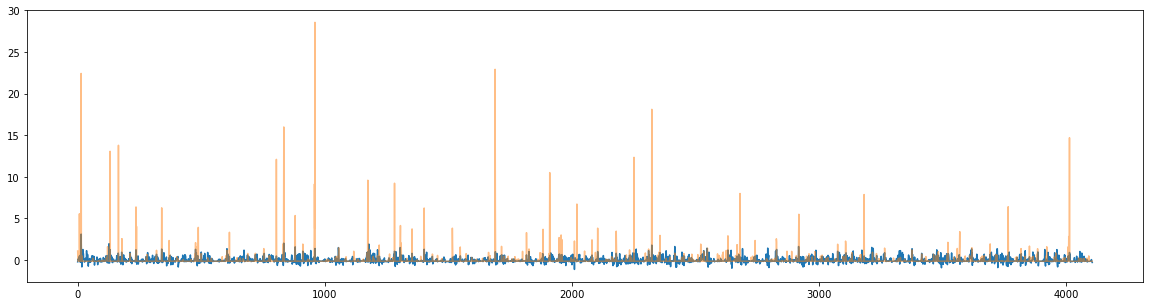

In [73]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(y)
ax.plot(traces[:,0], alpha=0.5)